# Tensorflow Sequential API 

### Introduction

In this project I show how to use the Tensorflow `sequential API within TF 2.0`. I will use the US Census Dataset and create a binary classification model. The data used has already been preprocessed, normalized and one-hot encoded. Data is stored within a Google Cloud Storage Bucket ready to be loaded into pandas dataframe or tensorflow dataset. 

### Import Libraries

In [19]:
from collections import namedtuple
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import datetime
import functools

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import feature_column

In [10]:
tf.__version__

'2.0.0-beta0'

### Load Data from Google Cloud Storage

In [11]:
#Specify data location
x_train_data = 'gs://crazy-hippo-01/dataset/x_train.csv'
x_test_data = 'gs://crazy-hippo-01/dataset/x_test.csv'
y_train_data = 'gs://crazy-hippo-01/dataset/y_train.csv'
y_test_data = 'gs://crazy-hippo-01/dataset/y_test.csv'
x_val = 'gs://crazy-hippo-01/dataset/x_val.csv'
y_val = 'gs://crazy-hippo-01/dataset/y_val.csv'

In [12]:
#Read CSV files into a Pandas Dataframe
X_train = pd.read_csv(x_train_data)
y_train = pd.read_csv(y_train_data)
X_test = pd.read_csv(x_test_data)
y_test = pd.read_csv(y_test_data)
x_val = pd.read_csv(x_val)
y_val = pd.read_csv(y_val)

### Create Tensorflow Dataset

In [13]:
FEATURES = X_train.columns
NUMERIC_COLS = X_train.columns[2:]
CATEGORICAL_COLS = X_train.columns[:2]

In [14]:
def create_dataset(x, y, batch_size, type='TRAIN'):
    
    #Load Pandas DF into tf dataset
    dataset = tf.data.Dataset.from_tensor_slices((dict(x), y.values))
    
    #Apply shuffle, batch and repeat to the training data. For evaluation we apply batch.
    if type == 'TRAIN': 
        dataset = dataset.shuffle(1000).batch(batch_size).repeat()
    else: 
        dataset = dataset.batch(32)
    
    # We take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(1)
    
    return dataset

In [15]:
temp_dataset = create_dataset(X_train, y_train, 32, 'TRAIN')

In [16]:
def show_batch(dataset):
    for data, label in dataset.take(1):
        for key, value in data.items():
            print("{:20s}: {}".format(key,value.numpy()))

In [ ]:
show_batch(temp_dataset)

### Build Model

In [20]:
def create_dnn_model(INPUTS, NUMERIC_COLS, CATEGORICAL_COLS):
    
    feature_columns = []
    
    # numeric cols
    for col in INPUTS:
        feature_columns.append(feature_column.numeric_column(col))
    
    # Create Feature and Input Layer
    feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

    
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['acc'])
    
    return model

seq_model = create_dnn_model(FEATURES, NUMERIC_COLS, CATEGORICAL_COLS)

print('Your model has been built....')
#func_model.summary()

Your model has been built....


### Input parameters

In [21]:
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = len(X_train) # training dataset repeats, so it will wrap around
EPOCHS = 5  # how many times to evaluate
NUM_EVAL_EXAMPLES = 100 # enough to get a reasonable sample, but not so much that it slows down

### Train Model

In [23]:
train_dataset = create_dataset(X_train, y_train, TRAIN_BATCH_SIZE, 'TRAIN')
eval_dataset = create_dataset(x_val, y_val, TRAIN_BATCH_SIZE, 'EVAL').take(NUM_EVAL_EXAMPLES)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * EPOCHS)


history = seq_model.fit(train_dataset,
     epochs= EPOCHS,
     verbose=1, 
     steps_per_epoch=steps_per_epoch, 
     validation_data=eval_dataset,
         )

Epoch 1/5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
153/153 [==============================] - 4s 24ms/step - loss: 0.4987 - acc: 0.7000 - val_loss: 0.4116 - val_acc: 0.8134
Epoch 2/5
153/153 [==============================] - 1s 7ms/step - loss: 0.4070 - acc: 0.8148 - val_loss: 0.3819 - val_acc: 0.8175
Epoch 3/5
153/153 [==============================] - 1s 8ms/step - loss: 0.3859 - acc: 0.8267 - val_loss: 0.3724 - val_acc: 0.8200
Epoch 4/5
153/153 [==============================] - 1s 8ms/step - loss: 0.3679 - acc: 0.8369 - val_loss: 0.3658 - val_acc: 0.8259
Epoch 5/5
153/153 [==============================] - 1s 8ms/step - loss: 0.3787 - acc: 0.8108 - val_loss: 0.3556 - val_acc: 0.8291


### Evaluate Model

In [24]:
test_dataset = create_dataset(X_test, y_test, TRAIN_BATCH_SIZE, 'TEST')

test_loss, test_acc = seq_model.evaluate(test_dataset, steps=20)

20/20 [==============================] - 0s 4ms/step - loss: 0.3533 - acc: 0.8391


### Visualize Training

In [25]:
import matplotlib.pyplot as plt

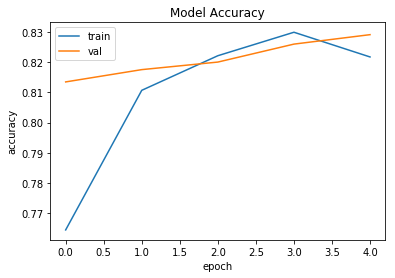

In [26]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()